In [1]:
import requests
from urllib.parse import urlencode
import zipfile

import numpy as np
from numpy.linalg import norm

import cv2
import torchvision

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Download data

In [3]:
# import requests
# from urllib.parse import urlencode

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/vr6SuXgW-8tgbg' # link

# final_url = base_url + urlencode (dict (public_key = public_key))
# response = requests.get(final_url)
# download_url = response.json () [ 'href']
# download_response = requests.get (download_url)
# with open( 'train.zip', 'wb') as f:
#     f.write (download_response.content)

In [4]:
# z = zipfile.ZipFile('train.zip')
# z.extractall()

In [5]:
data = torchvision.datasets.ImageFolder('train',transform=torchvision.transforms.ToTensor())
idx_to_classes = {v:k for (k,v) in data.class_to_idx.items()}

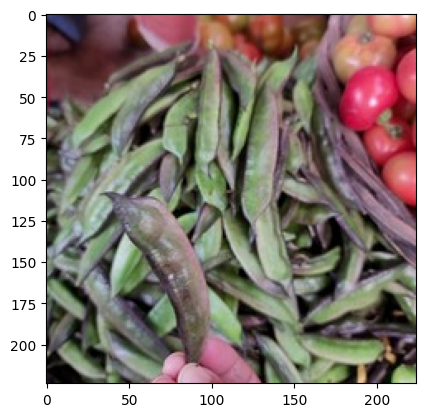

In [6]:
test_img = data[42][0].permute(1, 2, 0)
test_img.shape
plt.imshow(test_img);

## Image histograms and vectors

In [7]:
def image_hist(image, bins=32):
    img = image[0].permute(1, 2, 0).numpy()
    
    red = cv2.calcHist(
        [img], [2], None, [bins], [0, 1]
    )
    green = cv2.calcHist(
        [img], [1], None, [bins], [0, 1]
    )
    blue = cv2.calcHist(
        [img], [0], None, [bins], [0, 1]
    )
    
    return red, green, blue

In [8]:
def image_vector(image, bins=32):
    img = image[0].permute(1, 2, 0).numpy()
    
    red = cv2.calcHist(
        [img], [2], None, [bins], [0, 1]
    )
    green = cv2.calcHist(
        [img], [1], None, [bins], [0, 1]
    )
    blue = cv2.calcHist(
        [img], [0], None, [bins], [0, 1]
    )
    vector = np.concatenate([red, green, blue], axis=0)
    return vector.reshape(-1)

In [9]:
image_vectors = []
for img in data:
    image_vectors.append(image_vector(img)) # (15000,96)

## Search for top-k similar images

In [10]:
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [12]:
def search(idx, top_k=6):
    query_vector = image_vectors[idx]
    distances = []
    # count cosin distance between searched image and all vectors
    for vector in image_vectors:
        distances.append(cosine(query_vector, vector))
    # top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return list(top_idx[::-1]), distances

In [21]:
def plot_top_k(top_idx, distances):
    fig, ax = plt.subplots(nrows=2, ncols=6,figsize=(14, 5), sharey='row')

    for n, i in enumerate(top_idx):
        red, green, blue = image_hist(data[n])
        ax[0][n].imshow(data[i][0].permute(2, 1, 0))
        ax[0][n].set_title(f'{idx_to_classes[data[i][1]]}, Index - {i}')
        ax[1][n].plot(red, color='r')
        ax[1][n].plot(green, color='g')
        ax[1][n].plot(blue, color='b');
        ax[1][n].set_title(round(distances[i], 4))

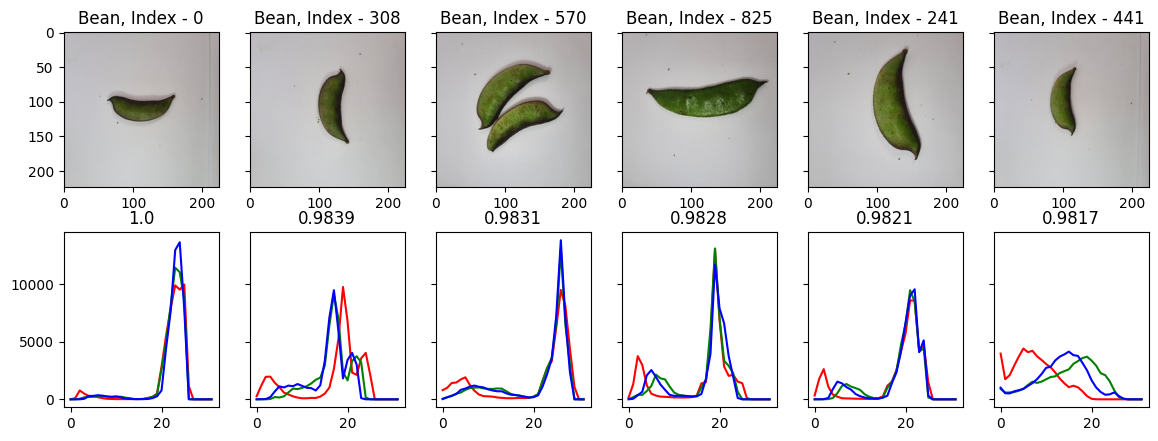

In [23]:
plot_top_k(*search(0))

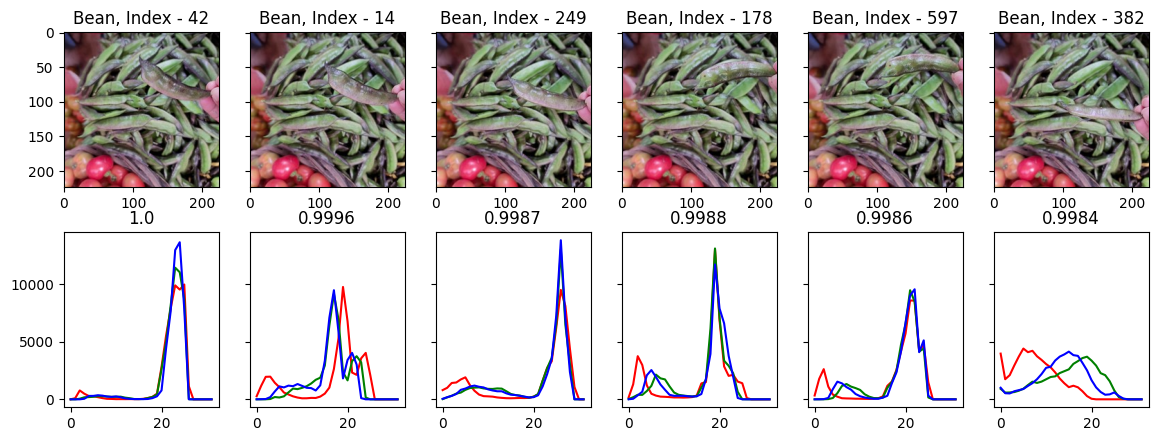

In [24]:
plot_top_k(*search(42))